# Feature Selection

@roman_avj
30 oct 2023

Feature Selection


In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from sklearn.pipeline import Pipeline, make_pipeline
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees
from scipy.integrate import simpson

# Data

In [2]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2_rent.parquet')
df_model.info()

[FATAL] 2023-11-12 18:43:29.582 Aws::Config::ConfigFileProfileFSM [0x2035a7280] Unknown parser error: unexpected state 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26541 entries, 0 to 26540
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 28.5+ MB


In [3]:
# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

In [5]:
print(df_model.columns.tolist())

['id', 'marketplace', 'first_observed_date', 'last_observed_date', 'count_repeated', 'time2event', 'event', 'id_sepomex', 'listing_type', 'property_type', 'is_development', 'is_exterior', 'is_penthouse', 'first_price', 'last_price', 'surface_total', 'num_bathrooms', 'num_parking_lots', 'num_bedrooms', 'cost_of_maintenance', 'is_new_property_prob', 'prediction_price', 'prediction_price_per_square_meter', 'longitude', 'latitude', 'has_balcony', 'has_elevator', 'has_garden', 'has_gym', 'has_luxury_features', 'has_pool', 'has_studio', 'has_surveillance', 'has_terrace', 'has_visitors_parking', 'has_washing_area', 'pets_allowed', 'page_on_marketplace', 'seller', 'tyear_start', 'tmonth_start', 'tquarter_start', 'available_secondary', 'delta_available_secondary', 'delta_available_secondary_lag1', 'delta_available_secondary_lag2', 'delta_available_secondary_lag3', 'available_secondary_lag1', 'available_secondary_lag2', 'available_secondary_lag3', 'ratio_available_to_total', 'delta_ratio_availab

# Select columns

In [6]:
# select columns
vars_x_categorical = ['listing_type', 'property_type']
vars_x_discrete = ['num_bedrooms', 'num_bathrooms', 'num_parking_lots']
vars_x_woe = ['woe_marketplace', 'woe_seller', 'woe_id_sepomex']
vars_x_numerical = [
    'first_price', 'diff_first_prediction', 
    'prediction_price_per_square_meter',
    'delta_available_secondary_lag1', 'delta_available_secondary_lag2', 'delta_available_secondary_lag3', 
    'delta_capital_gain_lag6', 'delta_capital_gain_lag3', 'delta_capital_gain_lag2', 'delta_capital_gain_lag1', 
    'delta_median_cap_rate_lag2', 'delta_median_cap_rate_lag1',
    'median_cap_rate_lag3', 'median_cap_rate_lag2', 'median_cap_rate_lag1',
    'surface_total', 'page_on_marketplace', 'views',
    'is_new_property_prob', 'total_cost_of_living', 'green_index', 'days_active',
    'relative_cost_of_living'
    ]
vars_x_binary = ['is_exterior', 'has_gym', 'has_studio', 'pets_allowed', 'has_maintenance']
vars_x_geographic = ['latitude', 'longitude']
vars_x_time = ['sine_tmonth', 'cosine_tmonth']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete + vars_x_geographic + vars_x_time + vars_x_woe

# corroborate there are not duplicates in the vars_x_names
print(len(vars_x_names))
print(len(set(vars_x_names)))

40
40


## Prepare data

In [7]:
# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['first_price'].div(1e+6))
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26541 entries, 0 to 26540
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   listing_type                       26541 non-null  category
 1   property_type                      26541 non-null  category
 2   first_price                        26541 non-null  float64 
 3   diff_first_prediction              26541 non-null  float64 
 4   prediction_price_per_square_meter  26541 non-null  float64 
 5   delta_available_secondary_lag1     26541 non-null  float64 
 6   delta_available_secondary_lag2     26541 non-null  float64 
 7   delta_available_secondary_lag3     26541 non-null  float64 
 8   delta_capital_gain_lag6            26541 non-null  float64 
 9   delta_capital_gain_lag3            26541 non-null  float64 
 10  delta_capital_gain_lag2            26541 non-null  float64 
 11  delta_capital_gain_lag1            26541 

In [8]:
# one hot encoding
data_x_numeric = OneHotEncoder().fit_transform(data_x)

colnames_x_numeric = data_x_numeric.columns
data_x_numeric.head(3)

dropped categorical variable 'listing_type', because it has only 1 values


,property_type=house,first_price,diff_first_prediction,prediction_price_per_square_meter,delta_available_secondary_lag1,delta_available_secondary_lag2,delta_available_secondary_lag3,delta_capital_gain_lag6,delta_capital_gain_lag3,delta_capital_gain_lag2,...,num_bedrooms,num_bathrooms,num_parking_lots,latitude,longitude,sine_tmonth,cosine_tmonth,woe_marketplace,woe_seller,woe_id_sepomex
0,0.0,8900.0,-0.097642,142.942667,0.058824,0.416667,0.090909,0.016079,0.011749,0.006852,...,2.0,2.0,1.0,19.478474,-99.210293,1.224647e-16,-1.000000,0.025046,0.065077,0.17534
1,0.0,8200.0,-0.145149,159.871995,0.058824,0.416667,0.090909,0.016079,0.011749,0.006852,...,2.0,1.0,1.4,19.478672,-99.206866,1.224647e-16,-1.000000,0.235393,0.065077,0.17534
2,0.0,7000.0,-0.255707,134.355634,0.000000,0.058824,0.416667,0.009225,0.006852,0.009923,...,2.0,1.0,1.6,19.479462,-99.207931,-5.000000e-01,-0.866025,-0.113731,0.065077,0.17534


In [9]:
# boxcox (yeo-johnson) transformation BY property type
def boxcox(X):
    # power_transform
    power_transform = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    X_transf = power_transform.transform(X)
    return X_transf, power_transform

# get boxcox transformation for each property type
boxcox_vars_property = [
    'first_price', 'prediction_price_per_square_meter', 'surface_total', 'is_new_property_prob'
]
# difference between vars_x_numerical and boxcox_vars_property
boxcox_vars_all = list(set(vars_x_numerical) - set(boxcox_vars_property))
# box cox transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get boxcox transformation
data_x_numeric.loc[idx_house, boxcox_vars_property], pt_house = boxcox(data_x_numeric.loc[idx_house, boxcox_vars_property])
data_x_numeric.loc[idx_apartment, boxcox_vars_property], pt_apartment = boxcox(data_x_numeric.loc[idx_apartment, boxcox_vars_property])
data_x_numeric[boxcox_vars_all], pt_all = boxcox(data_x_numeric[boxcox_vars_all])

In [10]:
# scale
def scale(X):
    # power_transform
    standard_scaler = StandardScaler().fit(X)
    X_transf = standard_scaler.transform(X)
    return X_transf, standard_scaler

# get scaler transformation for each property type
standard_vars = vars_x_discrete
# scaler transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get scaler transformation
data_x_numeric.loc[idx_house, standard_vars], st_house = scale(data_x_numeric.loc[idx_house, standard_vars])
data_x_numeric.loc[idx_apartment, standard_vars], st_apartment = scale(data_x_numeric.loc[idx_apartment, standard_vars])

In [14]:
# to numeric
data_x_numeric = data_x_numeric.to_numpy()
pd.DataFrame(data_x_numeric, columns=colnames_x_numeric).head(3)

,property_type=house,first_price,diff_first_prediction,prediction_price_per_square_meter,delta_available_secondary_lag1,delta_available_secondary_lag2,delta_available_secondary_lag3,delta_capital_gain_lag6,delta_capital_gain_lag3,delta_capital_gain_lag2,...,num_bedrooms,num_bathrooms,num_parking_lots,latitude,longitude,sine_tmonth,cosine_tmonth,woe_marketplace,woe_seller,woe_id_sepomex
0,0.0,-1.449619,-0.747566,-1.290174,-0.103614,1.210288,-0.188893,0.203176,0.027808,-0.285294,...,-0.130986,0.310737,-0.768490,19.478474,-99.210293,1.224647e-16,-1.000000,0.025046,0.065077,0.17534
1,0.0,-1.586037,-1.030759,-0.932039,-0.103614,1.210288,-0.188893,0.203176,0.027808,-0.285294,...,-0.130986,-1.097058,-0.170226,19.478672,-99.206866,1.224647e-16,-1.000000,0.235393,0.065077,0.17534
2,0.0,-1.847394,-1.738722,-1.486820,-0.368842,-0.230067,1.234406,-0.170551,-0.320270,-0.074497,...,-0.130986,-1.097058,0.128907,19.479462,-99.207931,-5.000000e-01,-0.866025,-0.113731,0.065077,0.17534


## Check Distributions

In [43]:
# get x data in pandas
df_postprocess = pd.DataFrame(data_x_numeric, columns=colnames_x_numeric).copy()

In [44]:
df_postprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26541 entries, 0 to 26540
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   property_type=house                26541 non-null  float64
 1   first_price                        26541 non-null  float64
 2   diff_first_prediction              26541 non-null  float64
 3   prediction_price_per_square_meter  26541 non-null  float64
 4   delta_available_secondary_lag1     26541 non-null  float64
 5   delta_available_secondary_lag2     26541 non-null  float64
 6   delta_available_secondary_lag3     26541 non-null  float64
 7   delta_capital_gain_lag6            26541 non-null  float64
 8   delta_capital_gain_lag3            26541 non-null  float64
 9   delta_capital_gain_lag2            26541 non-null  float64
 10  delta_capital_gain_lag1            26541 non-null  float64
 11  delta_median_cap_rate_lag2         26541 non-null  flo

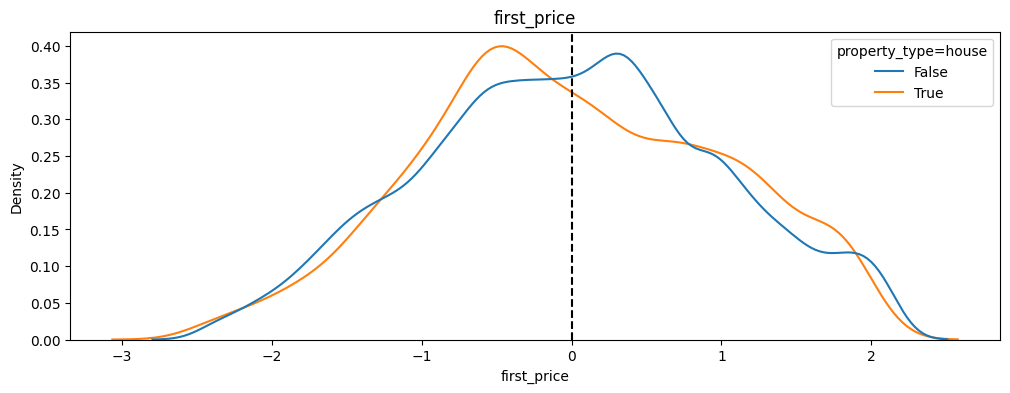

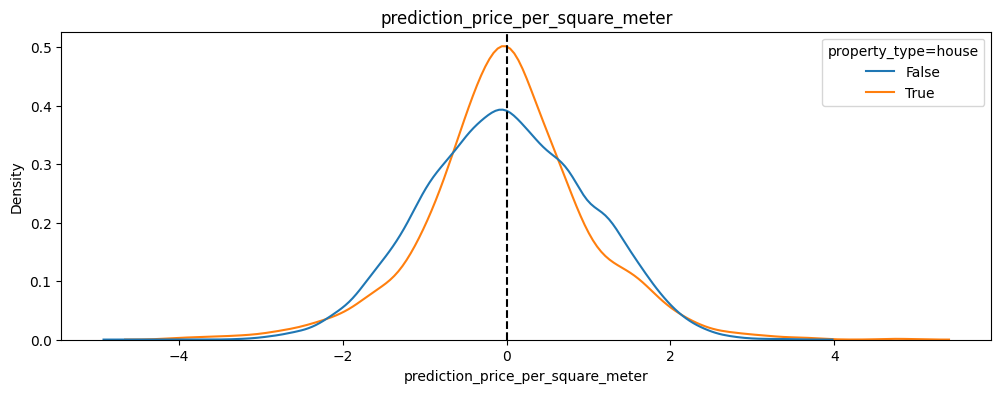

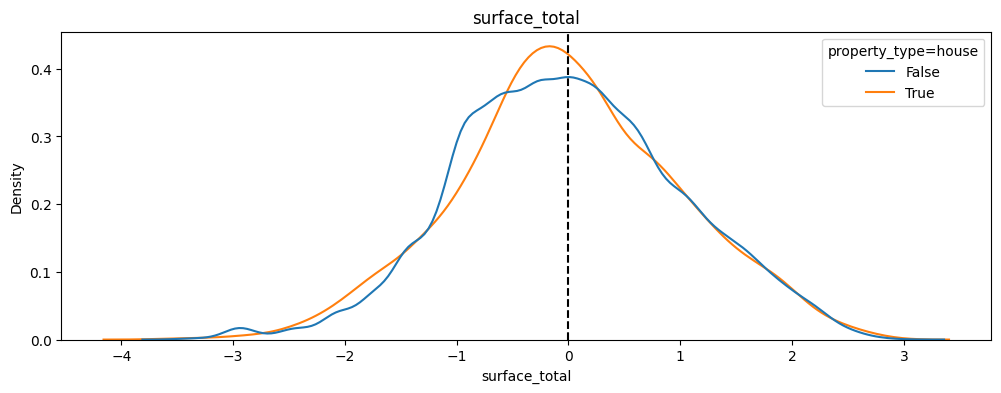

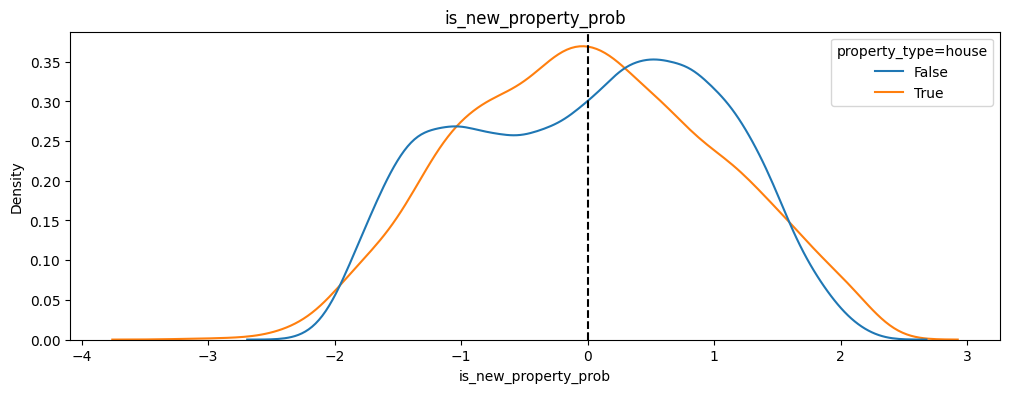

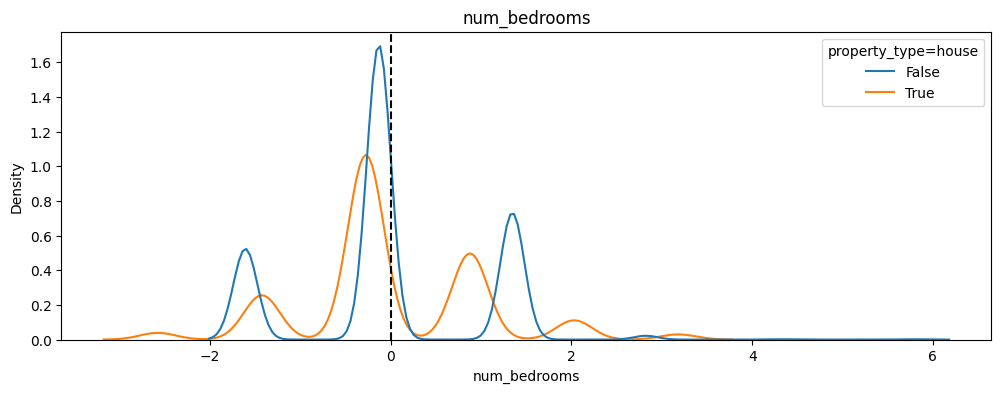

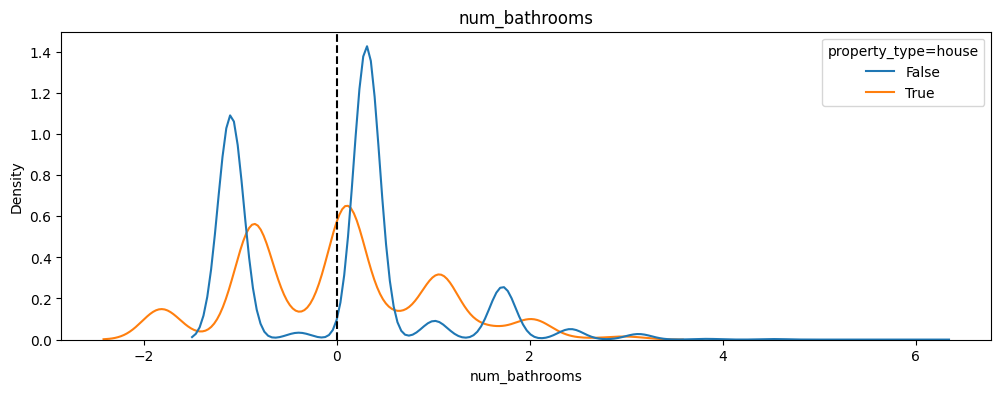

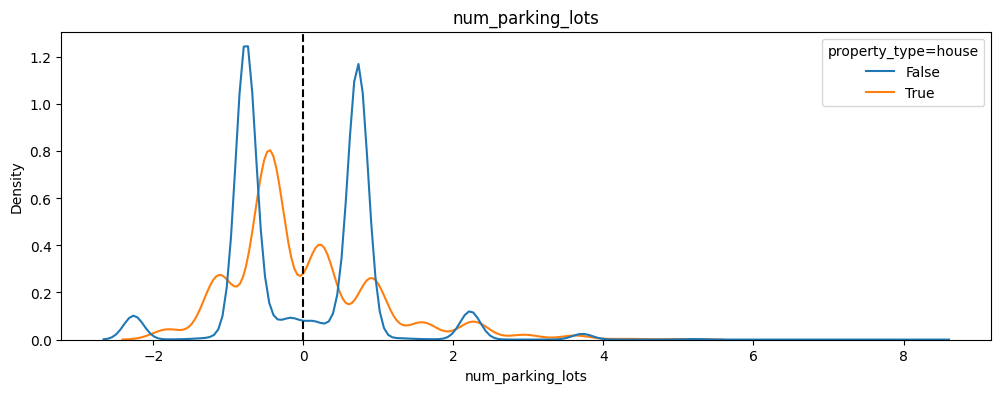

In [45]:
# look distribution of the variables boxcox_vars_property & standard_vars by property type
for col in boxcox_vars_property + standard_vars:
    fig, ax = plt.subplots(1, figsize=(12, 4))
    df_plot = df_postprocess[[col, 'property_type=house']].copy()
    df_plot['property_type=house'] = df_plot['property_type=house'].astype('bool')
    sns.kdeplot(data=df_plot, x=col, hue='property_type=house',common_norm=False)
    # add v line in 0 
    ax.axvline(0, color='black', linestyle='--')
    # add title
    ax.set_title(f'{col}')
    plt.show()

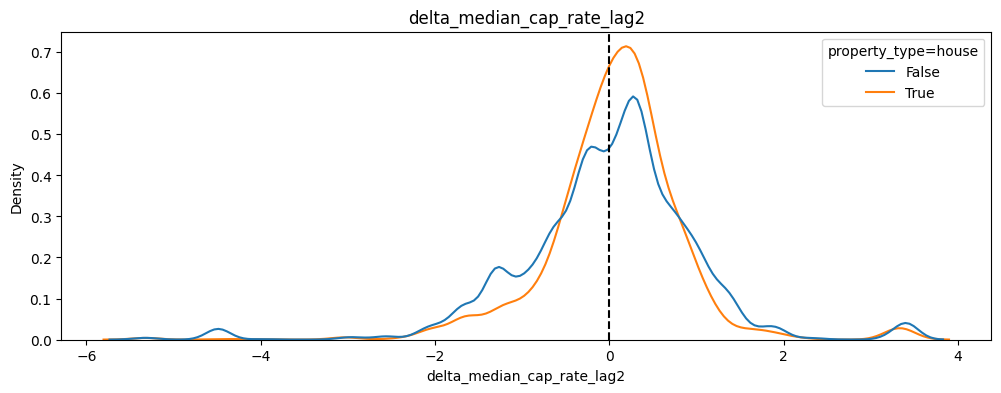

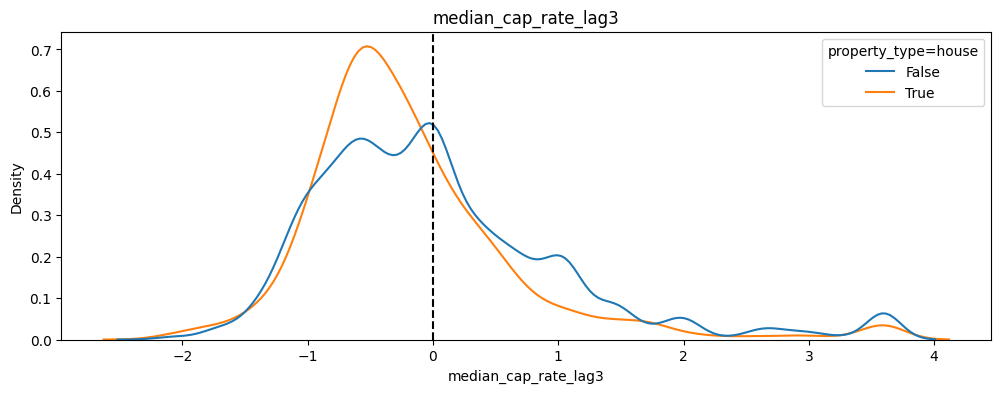

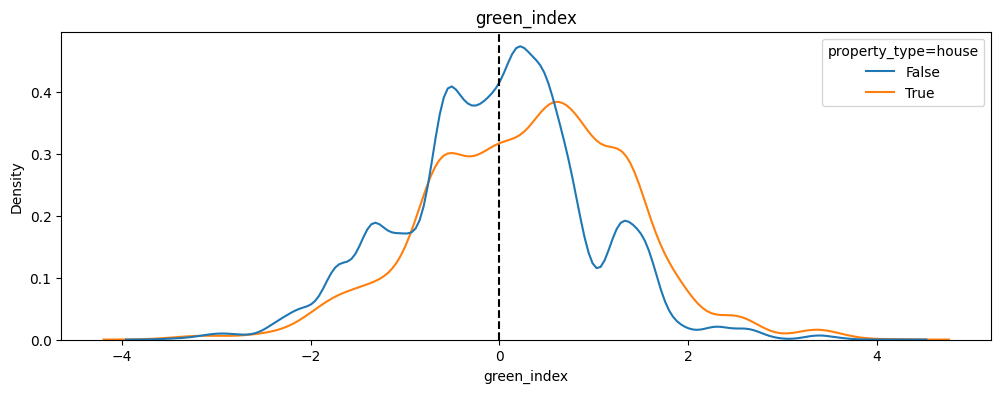

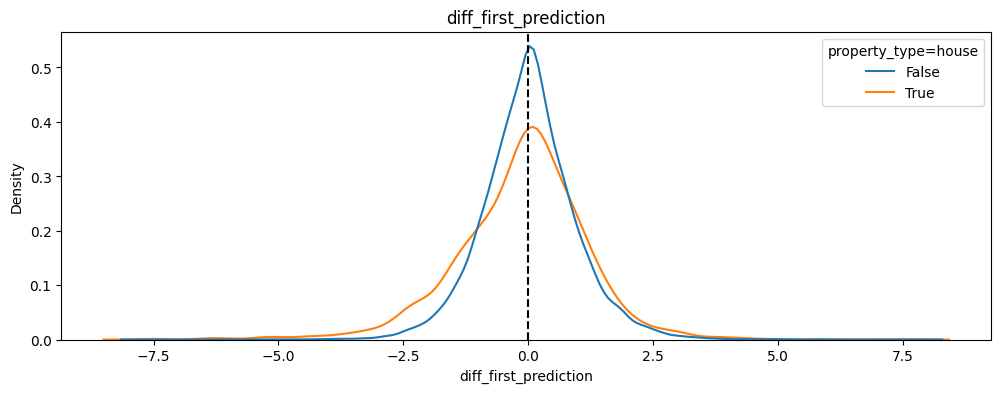

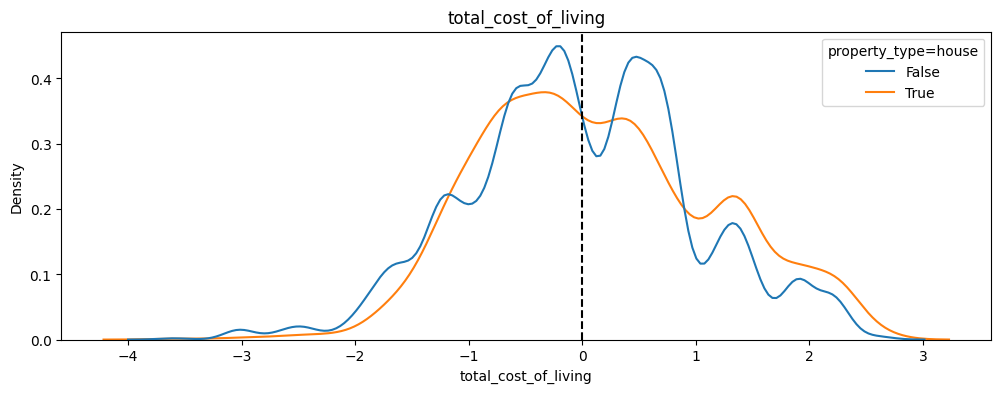

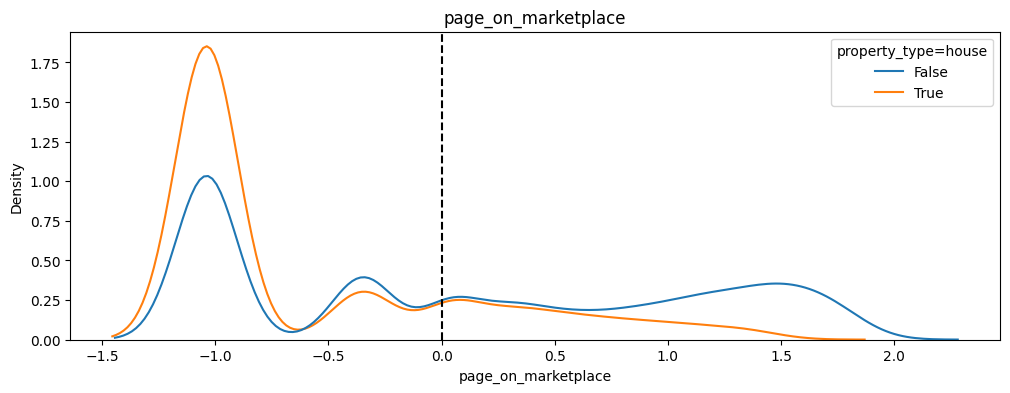

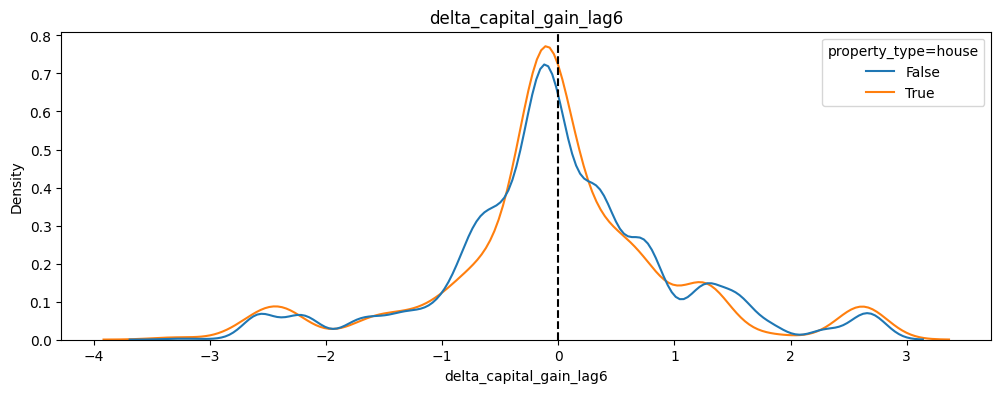

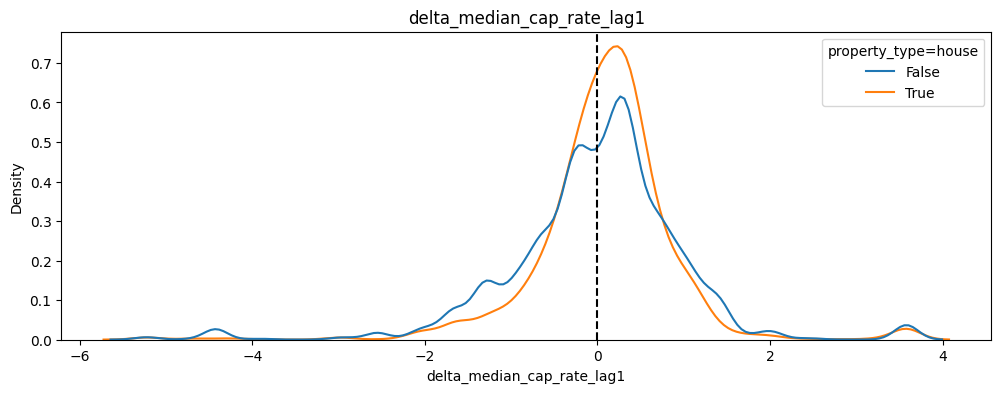

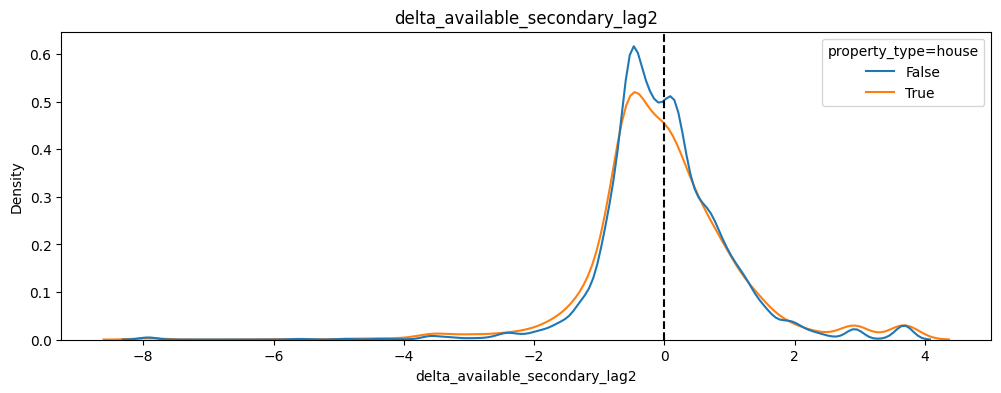

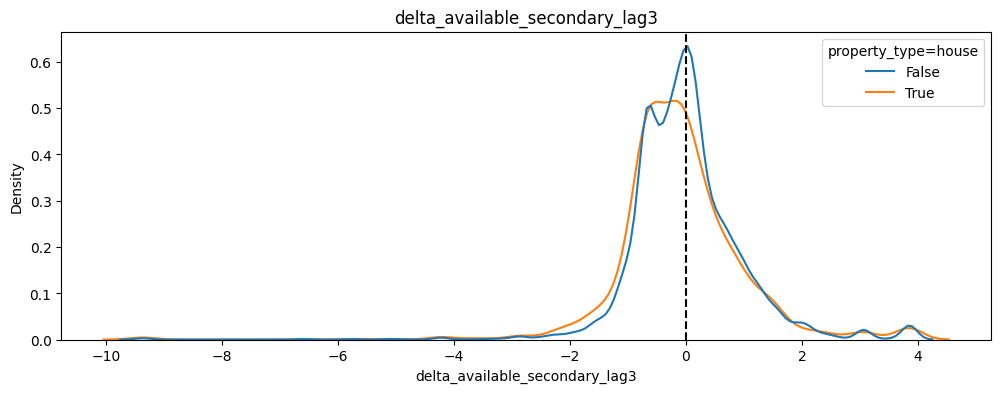

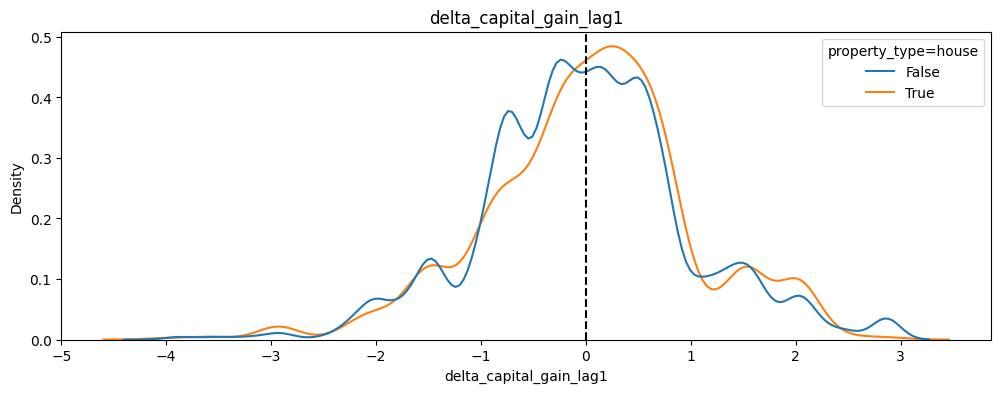

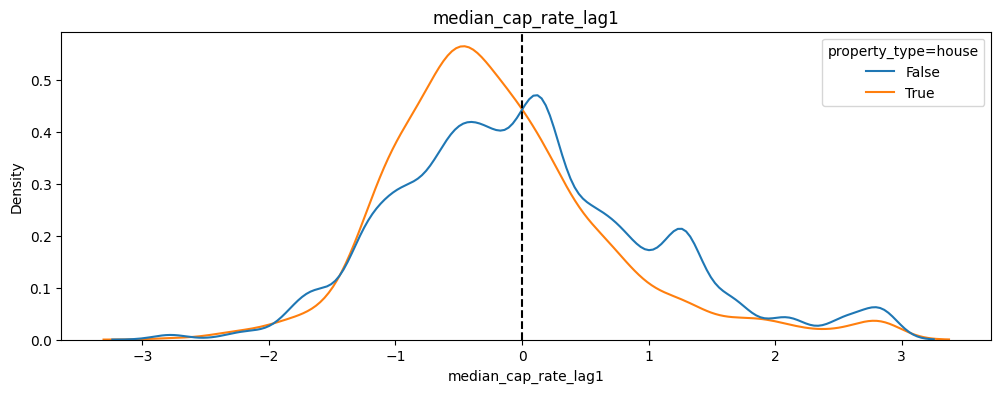

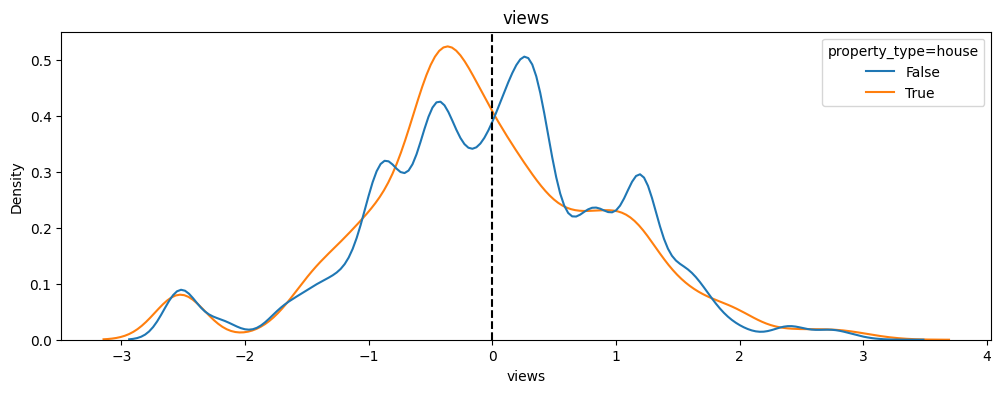

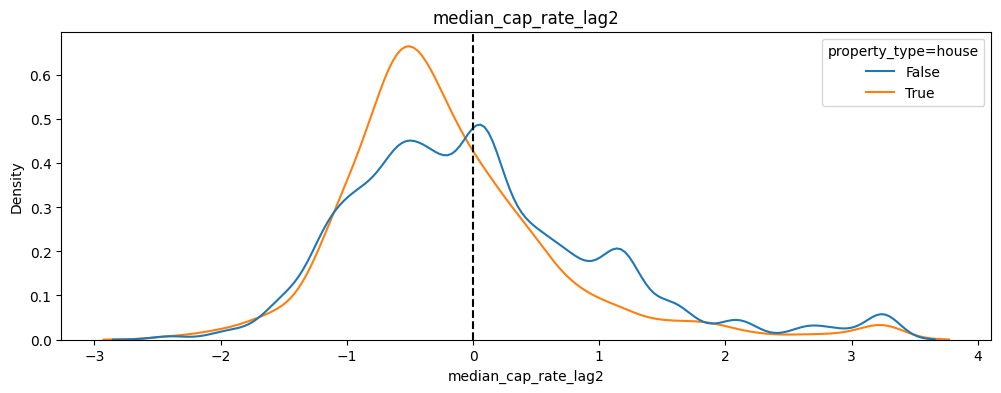

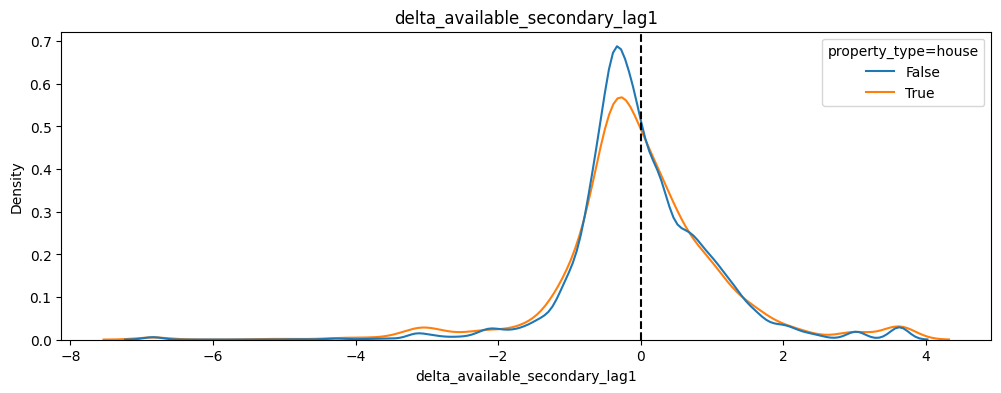

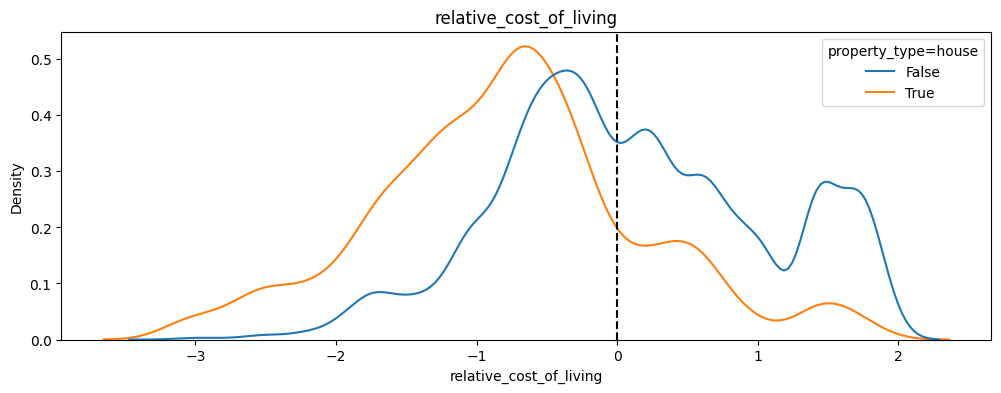

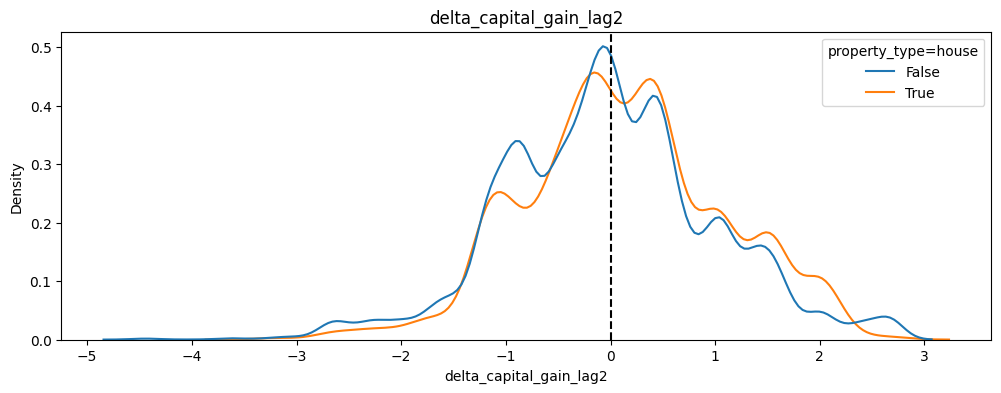

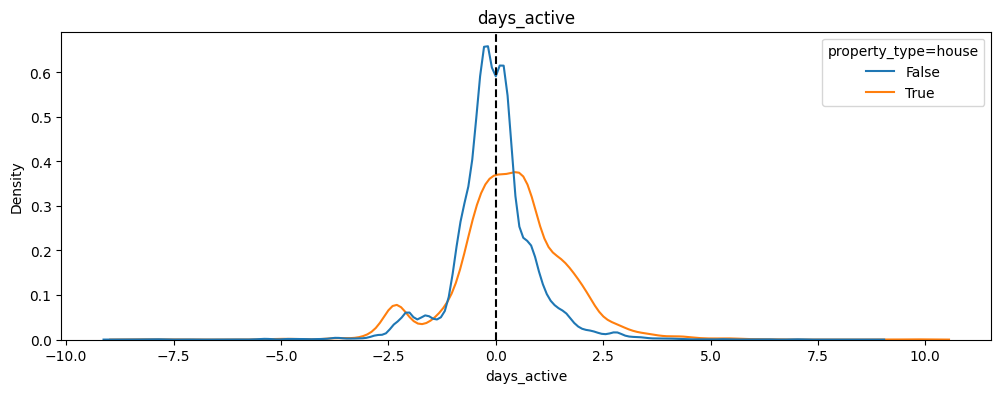

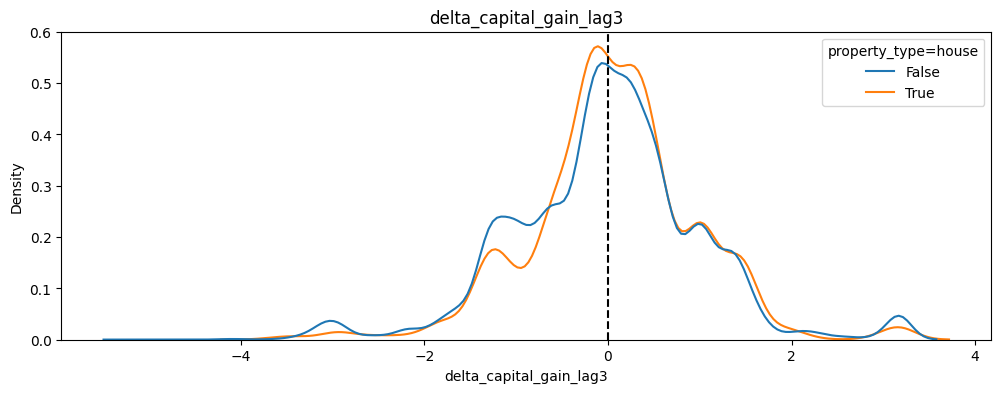

In [46]:
for col in boxcox_vars_all:
    fig, ax = plt.subplots(1, figsize=(12, 4))
    df_plot = df_postprocess[[col, 'property_type=house']].copy()
    df_plot['property_type=house'] = df_plot['property_type=house'].astype('bool')
    sns.kdeplot(data=df_plot, x=col, hue='property_type=house',common_norm=False)
    # add v line in 0 
    ax.axvline(0, color='black', linestyle='--')
    # add title
    ax.set_title(f'{col}')
    plt.show()

In [47]:
df_postprocess.describe()

,property_type=house,first_price,diff_first_prediction,prediction_price_per_square_meter,delta_available_secondary_lag1,delta_available_secondary_lag2,delta_available_secondary_lag3,delta_capital_gain_lag6,delta_capital_gain_lag3,delta_capital_gain_lag2,...,num_bedrooms,num_bathrooms,num_parking_lots,latitude,longitude,sine_tmonth,cosine_tmonth,woe_marketplace,woe_seller,woe_id_sepomex
count,26541.000000,2.654100e+04,2.654100e+04,2.654100e+04,2.654100e+04,2.654100e+04,2.654100e+04,2.654100e+04,2.654100e+04,2.654100e+04,...,2.654100e+04,2.654100e+04,2.654100e+04,26541.000000,26541.000000,26541.000000,26541.000000,26541.000000,26541.000000,26541.000000
mean,0.118684,1.799046e-15,-1.927549e-17,-1.456370e-16,9.262944e-17,4.069270e-17,1.177947e-17,6.853507e-17,7.228309e-18,-8.888142e-17,...,1.603614e-16,8.995228e-17,-4.711786e-17,19.386847,-99.189067,-0.195371,-0.573663,0.014075,0.074595,0.037408
std,0.323423,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,...,1.000019e+00,1.000019e+00,1.000019e+00,0.050290,0.049981,0.670650,0.427777,0.238894,0.578548,0.392806
min,0.000000,-2.464094e+00,-7.769872e+00,-4.522408e+00,-6.841484e+00,-7.923290e+00,-9.362207e+00,-3.292087e+00,-5.087102e+00,-4.440395e+00,...,-2.577287e+00,-1.815969e+00,-2.264151e+00,19.192221,-99.338870,-1.000000,-1.000000,-0.397016,-1.256267,-0.740097
25%,0.000000,-6.929480e-01,-5.571234e-01,-6.794744e-01,-4.827749e-01,-5.127309e-01,-5.865301e-01,-4.579983e-01,-5.859310e-01,-6.567096e-01,...,-1.309861e-01,-1.097058e+00,-7.684900e-01,19.357878,-99.215809,-0.866025,-0.866025,-0.113731,0.065077,-0.277533
50%,0.000000,-1.613304e-02,1.394000e-02,-1.443824e-02,-1.180204e-01,-8.242226e-02,-6.248051e-02,-5.389236e-02,2.014707e-02,-3.096438e-02,...,-1.309861e-01,3.107368e-01,-1.702257e-01,19.386880,-99.181922,-0.500000,-0.866025,0.025046,0.065077,0.175340
75%,0.000000,6.654551e-01,5.596183e-01,6.861760e-01,4.857931e-01,4.838093e-01,4.129997e-01,4.226034e-01,5.272611e-01,5.400708e-01,...,8.773744e-01,3.107368e-01,7.271709e-01,19.429630,-99.159850,0.500000,-0.500000,0.235393,0.065077,0.175340
max,1.000000,2.104728e+00,7.910156e+00,4.802588e+00,3.633040e+00,3.681008e+00,3.855197e+00,2.740009e+00,3.172089e+00,2.664539e+00,...,5.778169e+00,5.941916e+00,8.205476e+00,19.547668,-98.982450,1.000000,0.500000,0.235393,1.810651,1.282975


## Split data

In [61]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.1, random_state=42, stratify=data_x['listing_type']
)

## Elastic Net Cox Model

### Naive

In [64]:
X_train.shape

(23886, 39)

In [122]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=1, alphas=np.logspace(-5, 2, 10))
cox_elastic_net.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=array([1.00000000e-05, 5.99484250e-05, 3.59381366e-04, 2.15443469e-03,
       1.29154967e-02, 7.74263683e-02, 4.64158883e-01, 2.78255940e+00,
       1.66810054e+01, 1.00000000e+02]),
                       l1_ratio=1)

In [123]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(12, 12))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], "-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

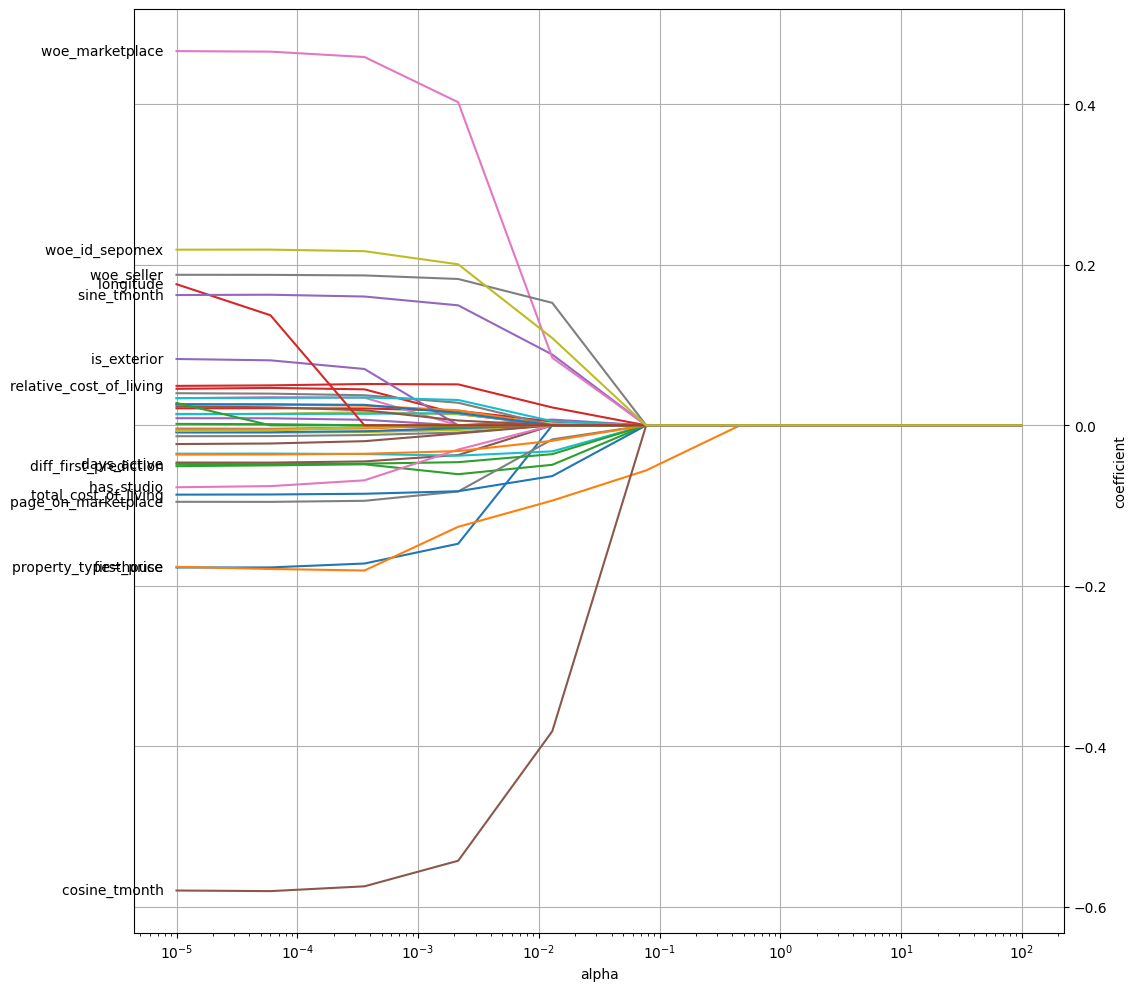

In [124]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=colnames_x_numeric, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=15)

### Random Forest

In [111]:
from sklearn.inspection import permutation_importance

rsf = ExtraSurvivalTrees(
    n_estimators=100, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42
)
rsf.fit(X_train, y_train)

ExtraSurvivalTrees(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                   random_state=42)

In [129]:
result = permutation_importance(rsf, X_train, y_train, n_repeats=3, random_state=42)

In [130]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=colnames_x_numeric,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
cosine_tmonth,0.048900,0.002290
sine_tmonth,0.030503,0.001572
woe_marketplace,0.025726,0.000341
first_price,0.012007,0.000137
page_on_marketplace,0.011751,0.000243
woe_seller,0.011557,0.000587
woe_id_sepomex,0.008356,0.000402
pets_allowed,0.006633,0.000022
total_cost_of_living,0.006235,0.000184
num_parking_lots,0.004407,0.000185


# Conclusions

## linear model

Using the elastic net, I see that the most important features are:
- woes (good predictor)
- tmonth (good predictor)
- total_cost (good predictor)
- diff price (good predictor)
- page_on_marketplace (good predictor)
- first_price (good predictor)
- property_type (fare predictor)
- cost_of_living
- days_active
- is_exterior


## non-linear feature importance

Using random forest to select features, we can see that the most important features are:
- tmonth
- woe marketplace
- first price
- page on marketplace
- woe seller
- woe sepomex
- pets allowed
- total cost
- num parking
- has gym
- surface